In [1]:
import os
import sys

In [2]:
%matplotlib inline

from matplotlib import rc
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow, quiver

In [3]:
import scipy
from scipy import ndimage as ndi
import networkx as nx

In [4]:
import numpy as np
from numpy.random import randn

In [5]:
import astromorpho as astro

Can't load imreg package, affine and homography registrations won't work


/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(


# Тестовая картинка

Линии

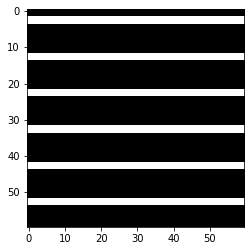

In [8]:
img_lines = np.zeros((100,100))
img_lines[2::10] = 1
img_lines[3::10] = 1
img_lines = img_lines[20:-20,20:-20]

img_lines = np.clip(img_lines, 0, 1)
crop = (slice(20,-20), slice(20,-20))
img = img_lines
imshow(img, cmap='gray')

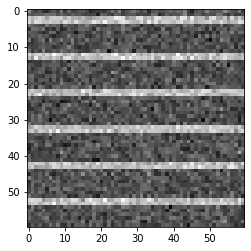

In [9]:
SNR = 5
img_noisy = SNR*img + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Сетка

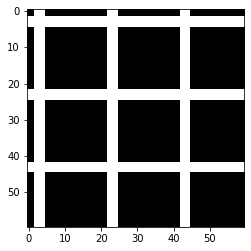

In [80]:
img_lines = np.zeros((100,100))
img_lines[2::20] = 1
img_lines[3::20] = 1
img_lines[4::20] = 1

img_lines[..., 2::20] = 1
img_lines[..., 3::20] = 1
img_lines[..., 4::20] = 1

# img_lines = img_lines[20:-20,20:-20]

img_lines = np.clip(img_lines, 0, 1)
crop = (slice(20,-20), slice(20,-20))
img = img_lines[crop]
imshow(img, cmap='gray')

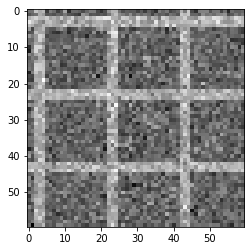

In [81]:
SNR = 3
img_noisy = SNR*img + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Косая Сетка

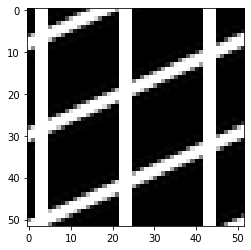

In [133]:
img_lines = np.zeros((100,100))
img_lines[2::20] = 1
img_lines[3::20] = 1
img_lines[4::20] = 1

img_lines = ndi.rotate(img_lines, 24)

img_lines[..., 2::20] = 1
img_lines[..., 3::20] = 1
img_lines[..., 4::20] = 1

img_lines = img_lines[20:-20,20:-20]

img_lines = np.clip(img_lines, 0, 1)
crop = (slice(20,-20), slice(20,-20))
img = img_lines[crop]
imshow(img, cmap='gray')

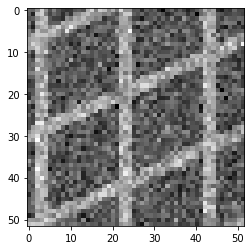

In [134]:
SNR = 3
img_noisy = SNR*img + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Повернутый крест

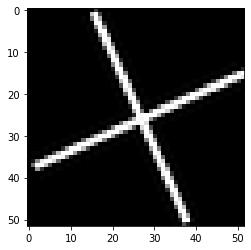

In [123]:
img_cross = np.zeros((100,100))
img_cross[50:52, 23:78] = 1
img_cross[23:78,50:52] = 1
img_cross = ndi.rotate(img_cross, 24)
img_cross = img_cross[20:-20,20:-20]

img_cross = np.clip(img_cross, 0, 1)
crop = (slice(20,-20), slice(20,-20))
img = img_cross[crop]
imshow(img, cmap='gray', interpolation='nearest')

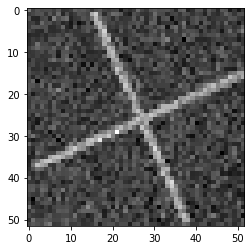

In [124]:
SNR = 5
img_noisy = SNR*img + randn(*img.shape)
imshow(img_noisy, cmap='gray',interpolation='nearest')

Спираль

In [12]:
from PIL import Image

pic = Image.open("/home/incredible/Neuroscience/Code/data/test_images/spiral.png").convert('L')
img = np.clip(np.asarray(pic), 0, 1)
imshow(img, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: '/home/incredible/Neuroscience/Code/data/test_images/spiral.png'

In [ ]:
SNR = 5
img_noisy = img*SNR + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Астроцит (типа)

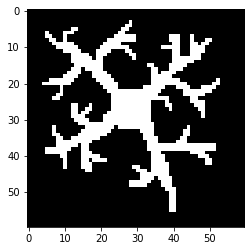

In [152]:
from PIL import Image

pic = Image.open("/home/incredible/Neuroscience/Code/data/test_images/astro.png").convert('L')
img = np.clip(np.asarray(pic), 0, 1)
imshow(img, cmap='gray')

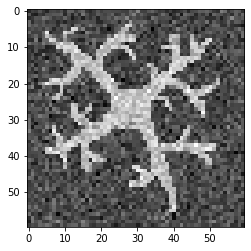

In [153]:
SNR = 5
img_noisy = img*SNR + randn(*img.shape)
imshow(img_noisy, cmap='gray')

Астроцит (реальный)

In [6]:
import ccdb

In [7]:
filename = '/home/levtg/astro-morpho/data/3wk-ly16-raw.pic'

In [8]:
stack, meta = ccdb.read_pic(filename)
dims = ccdb.get_axes(meta)#[::-1]
dims

[(0.0560606, "Microns'"), (0.0560606, "Microns'"), (0.25, "Microns'")]

In [9]:
if len(dims):
    zoom = dims[0][0]/dims[-1][0]
else:
    zoom = 4

In [10]:
img_noisy = ndi.zoom(stack.astype(float),(1, zoom,zoom))

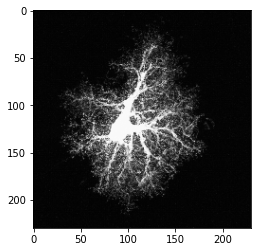

In [11]:
plt.imshow(img_noisy.max(0), cmap='gray')

## Фильтрация изображения

In [12]:
from skimage.filters import threshold_li
from skimage.morphology import remove_small_objects

In [13]:
li = threshold_li(img_noisy)

In [14]:
clear_img = np.where(img_noisy > li, img_noisy, 0)
clearest_img = remove_small_objects(img_noisy >= li, 5, connectivity=3)
final_image = np.where(clearest_img, clear_img, 0)

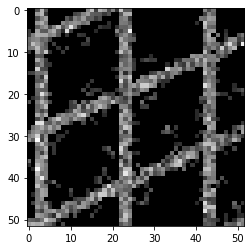

In [138]:
imshow(final_image, cmap='gray')

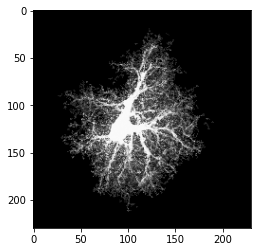

In [15]:
plt.imshow(final_image.max(0), cmap='gray')

# Вектора Гессе

In [139]:
sigma = 2

In [140]:
sato, Vf = astro.hessian.sato2d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

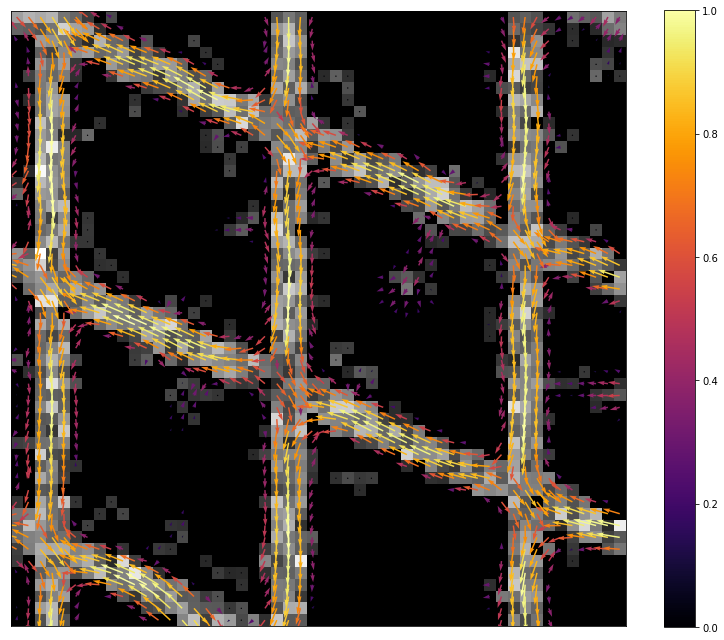

In [141]:
plt.figure(figsize=(11,9))
imshow(final_image, cmap='gray', origin='lower')

weights = astro.enh.percentile_rescale(sato)**0.5

i = 0
Vfx = Vf[...,i][...,::-1]

V = Vfx[...,0] # row directions (Y)
U = Vfx[...,1] # col directions (X)
plt.setp(plt.gca(), xticks=[], yticks=[])
h = quiver(U*weights, V*weights, weights, scale=25, cmap='inferno')
plt.colorbar(h, ax=plt.gca())
plt.tight_layout()

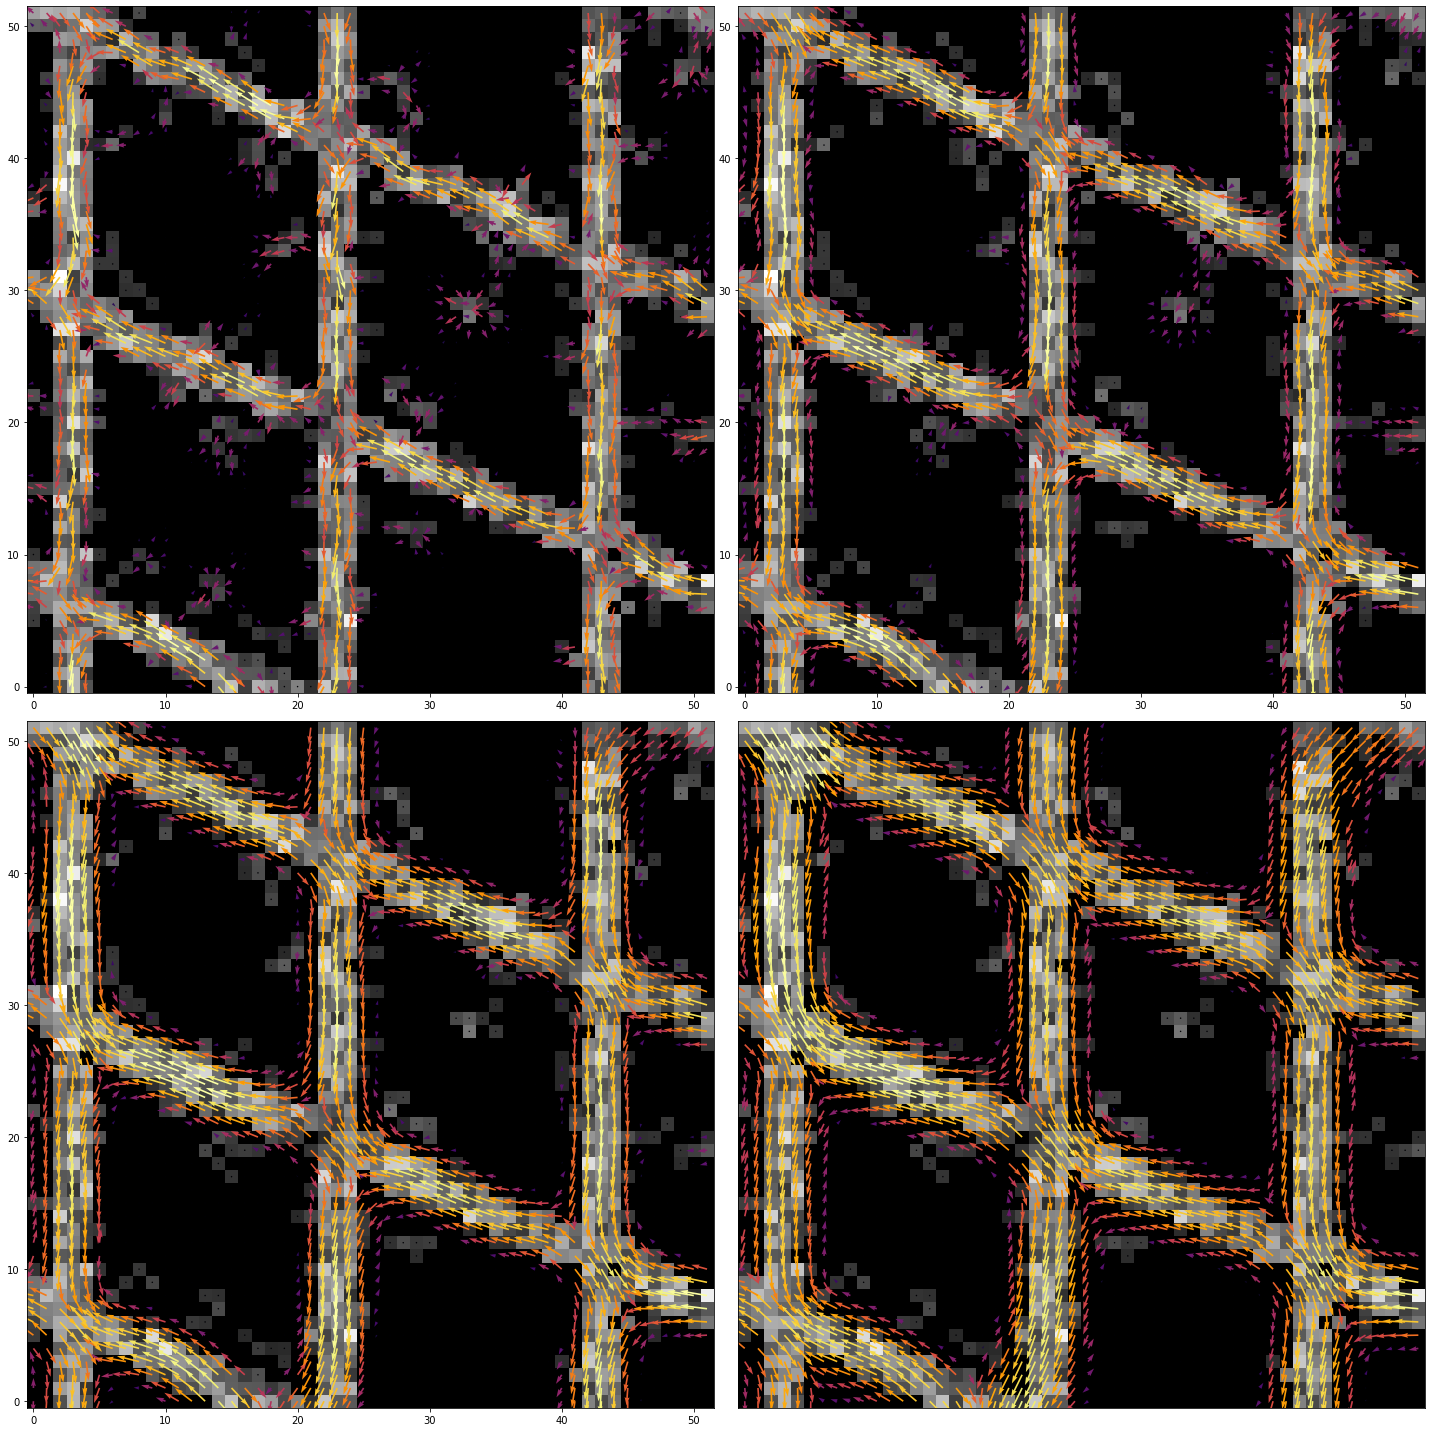

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

sigma = 1
sato, Vf = astro.hessian.sato2d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

ax = axes[0][0]
ax.imshow(final_image, cmap='gray', origin='lower')

weights = astro.enh.percentile_rescale(sato)**0.5
i = 0
Vfx = Vf[...,i][...,::-1]
V = Vfx[...,0] # row directions (Y)
U = Vfx[...,1] # col directions (X)
h = ax.quiver(U*weights, V*weights, weights, scale=25, cmap='inferno')


sigma = 2
sato, Vf = astro.hessian.sato2d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

ax = axes[0][1]
ax.imshow(final_image, cmap='gray', origin='lower')

weights = astro.enh.percentile_rescale(sato)**0.5
i = 0
Vfx = Vf[...,i][...,::-1]
V = Vfx[...,0] # row directions (Y)
U = Vfx[...,1] # col directions (X)
h = ax.quiver(U*weights, V*weights, weights, scale=25, cmap='inferno')


sigma = 3
sato, Vf = astro.hessian.sato2d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

ax = axes[1][0]
ax.imshow(final_image, cmap='gray', origin='lower')

weights = astro.enh.percentile_rescale(sato)**0.5
i = 0
Vfx = Vf[...,i][...,::-1]
V = Vfx[...,0] # row directions (Y)
U = Vfx[...,1] # col directions (X)
h = ax.quiver(U*weights, V*weights, weights, scale=25, cmap='inferno')


sigma = 4
sato, Vf = astro.hessian.sato2d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

ax = axes[1][1]
ax.imshow(final_image, cmap='gray', origin='lower')

weights = astro.enh.percentile_rescale(sato)**0.5
i = 0
Vfx = Vf[...,i][...,::-1]
V = Vfx[...,0] # row directions (Y)
U = Vfx[...,1] # col directions (X)
h = ax.quiver(U*weights, V*weights, weights, scale=25, cmap='inferno')

plt.setp(plt.gca(), xticks=[], yticks=[])
plt.tight_layout()

# Построение графа ветвей

В качестве веса ребер будем брать косинусное расстояние между ними

x, y, vectors, weights, img_noisy

In [89]:
lengths = astro.enh.percentile_rescale(sato)**0.5

In [90]:
vectors = np.stack((U*lengths, V*lengths), axis=2)

In [91]:
nr, nc = (1, U.shape[0]) if U.ndim == 1 else U.shape
x, y = np.meshgrid(np.arange(nc), np.arange(nr))

In [92]:
def weight_of(a, b):
    try:
        cos_dist = scipy.spatial.distance.cosine(a, b)
    except:
        cos_dist = 0
    return np.abs(1 - cos_dist) * np.mean([np.linalg.norm(a), np.linalg.norm(b)])

In [93]:
k_h, k_w = 3, 3

In [94]:
G = nx.Graph()
nodes = {}

In [95]:
for row in range(vectors.shape[0]):
    for col in range(vectors.shape[1]):
        cur = (row, col)
        cur_node = (x[cur], y[cur])
        nodes[cur_node] = cur_node
        G.add_node(cur_node, size=final_image[cur])
        for i in range(k_w):
            for j in range(k_h):
                pos = (np.clip(row + i - k_w//2, 0, U.shape[0] - 1), np.clip(col + j - k_h//2, 0, U.shape[1] - 1)) 
                pos_node = (x[pos], y[pos])
                if G.has_edge(cur_node, pos) or cur_node == pos_node:
                    continue
                weight = weight_of(vectors[cur], vectors[pos])
                if weight < 10e-3:
                    continue
                nodes[pos_node] = pos_node
                G.add_edge(cur_node, pos_node, weight=weight)
                

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Считаем, что точки находятся на одной линии если угол между ними не превышает 45 градусов, т.е. значение весов >= 0.7

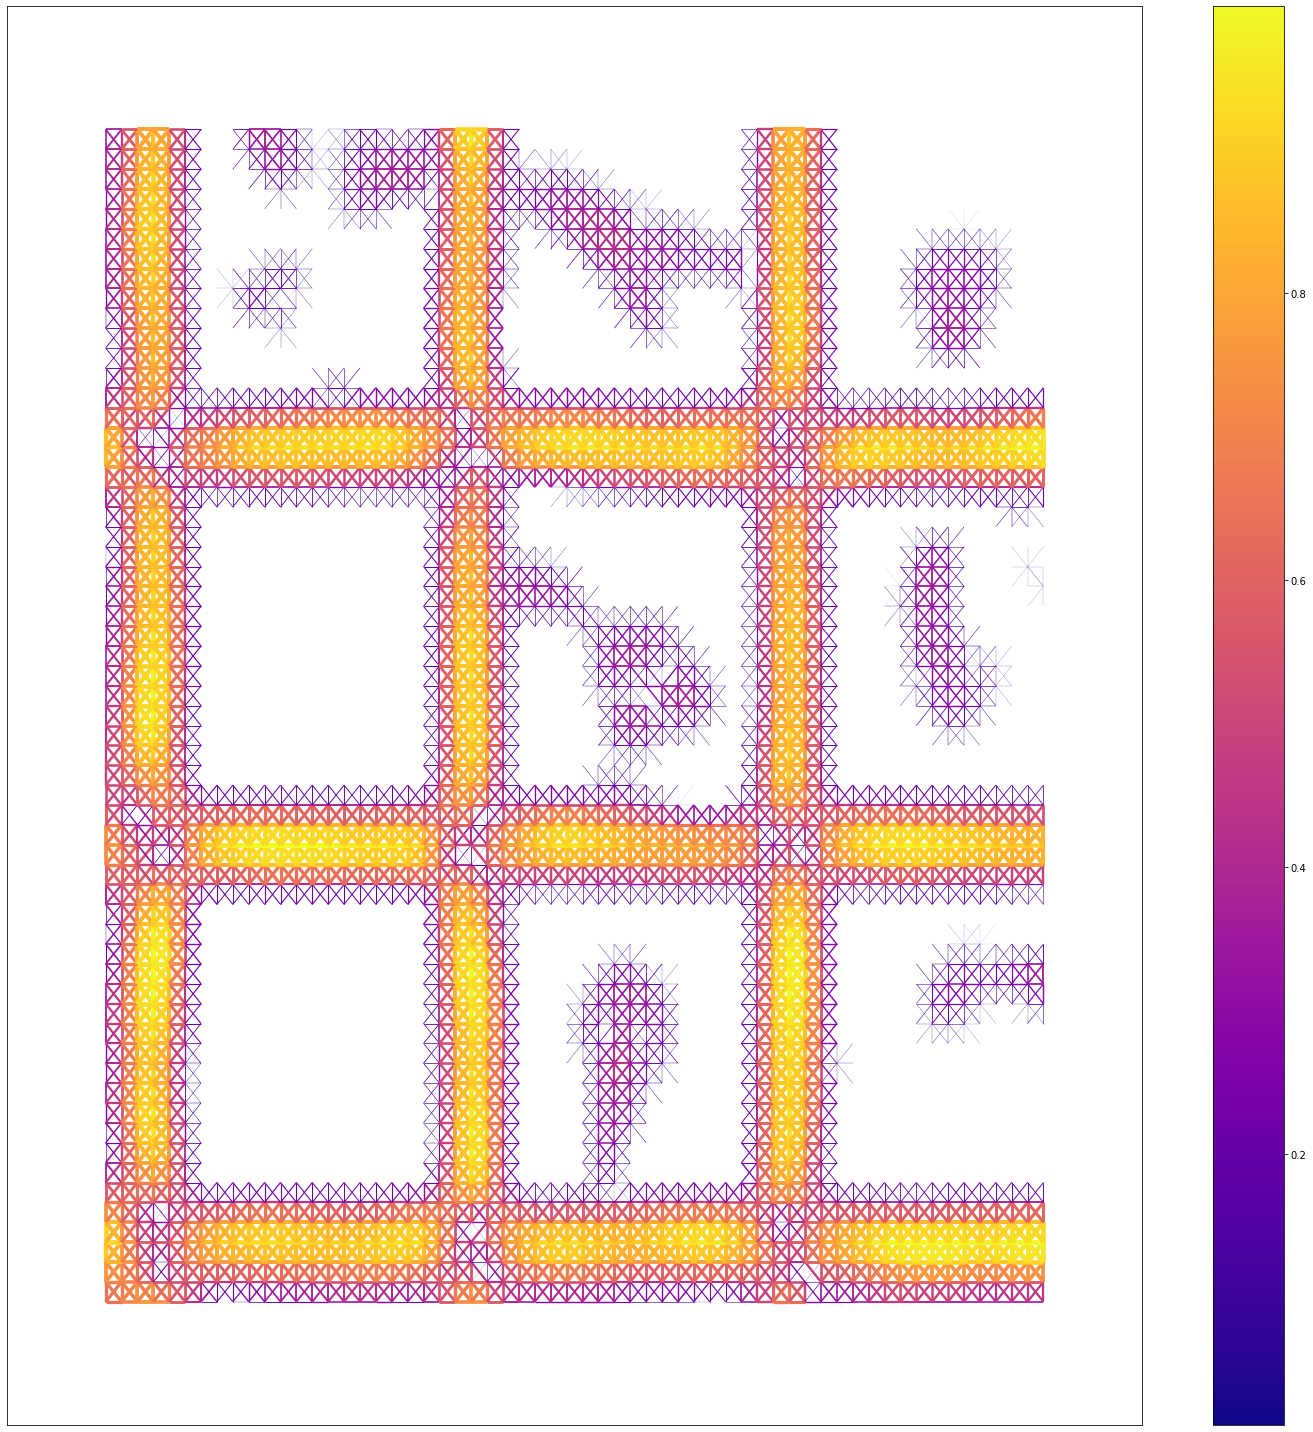

In [113]:
# %matplotlib notebook
plt.figure(figsize=(20, 20))
width = np.array([edgedata["weight"] for _, _, edgedata in G.edges(data=True)])
# width = np.where(width < 0.3, np.zeros(width.shape), width)
edges = nx.draw_networkx_edges(G, nodes, width=width*5, edge_cmap = plt.cm.plasma, edge_color=width)
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.colorbar(edges, ax=plt.gca())
plt.tight_layout()
# imshow(clean_img, cmap='gray', origin='lower')

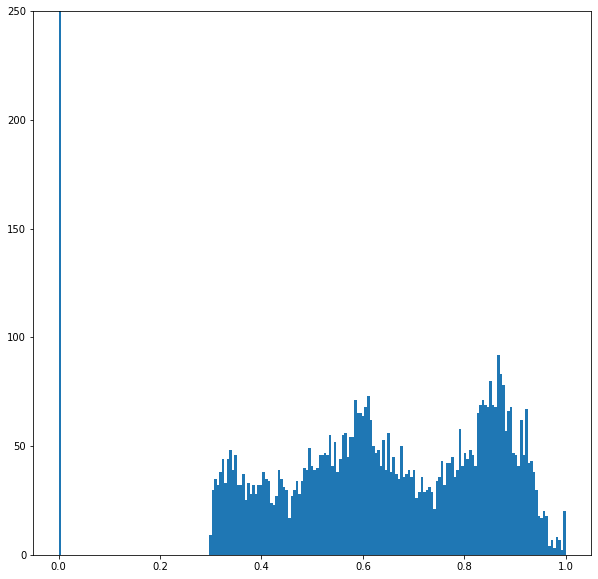

In [97]:
plt.figure(figsize=(10, 10))
# plt.scatter(np.arange(0, width.shape[0]), width)
plt.hist(width, bins=199)
plt.ylim((0, 250))
plt.show()

In [98]:
from skimage.filters import threshold_li, threshold_otsu

In [99]:
otsu, li = threshold_otsu(width), threshold_li(width)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/skimage/filters/thresholding.py:757: RuntimeWarning: divide by zero encountered in log
  / (np.log(mean_back) - np.log(mean_fore)))


# Построение графа узлов

В отличие от предыдущего пункта определяем узлы как места со слабыми связями рядом с сильными. Вес считается как косинусное растояние без учитывания длин векторов. (Можно откомментировать и будет как в пункте выше)

Слабыми считаются связи у которых вес ~0; т е угол между соседними векторами порядка 90

In [102]:
def weight_of(a, b):
    try:
        cos_dist = scipy.spatial.distance.cosine(a, b)
    except:
        cos_dist = 0
    return np.abs(1 - cos_dist) #* np.mean([np.linalg.norm(a), np.linalg.norm(b)])

In [103]:
Gn = nx.Graph()
nodes_n = {}
weights = []

In [104]:
for row in range(vectors.shape[0]):
    for col in range(vectors.shape[1]):
        cur = (row, col)
        cur_node = (x[cur], y[cur])
        nodes[cur_node] = cur_node
        Gn.add_node(cur_node, size=final_image[cur])
        for i in range(k_w):
            for j in range(k_h):
                pos = (np.clip(row + i - k_w//2, 0, U.shape[0] - 1), np.clip(col + j - k_h//2, 0, U.shape[1] - 1)) 
                pos_node = (x[pos], y[pos])
                if Gn.has_edge(cur_node, pos) or cur_node == pos_node:
                    continue
                weight = weight_of(vectors[cur], vectors[pos])
                weights.append(weight)
                nodes[pos_node] = pos_node
                Gn.add_edge(cur_node, pos_node, weight=weight)
                

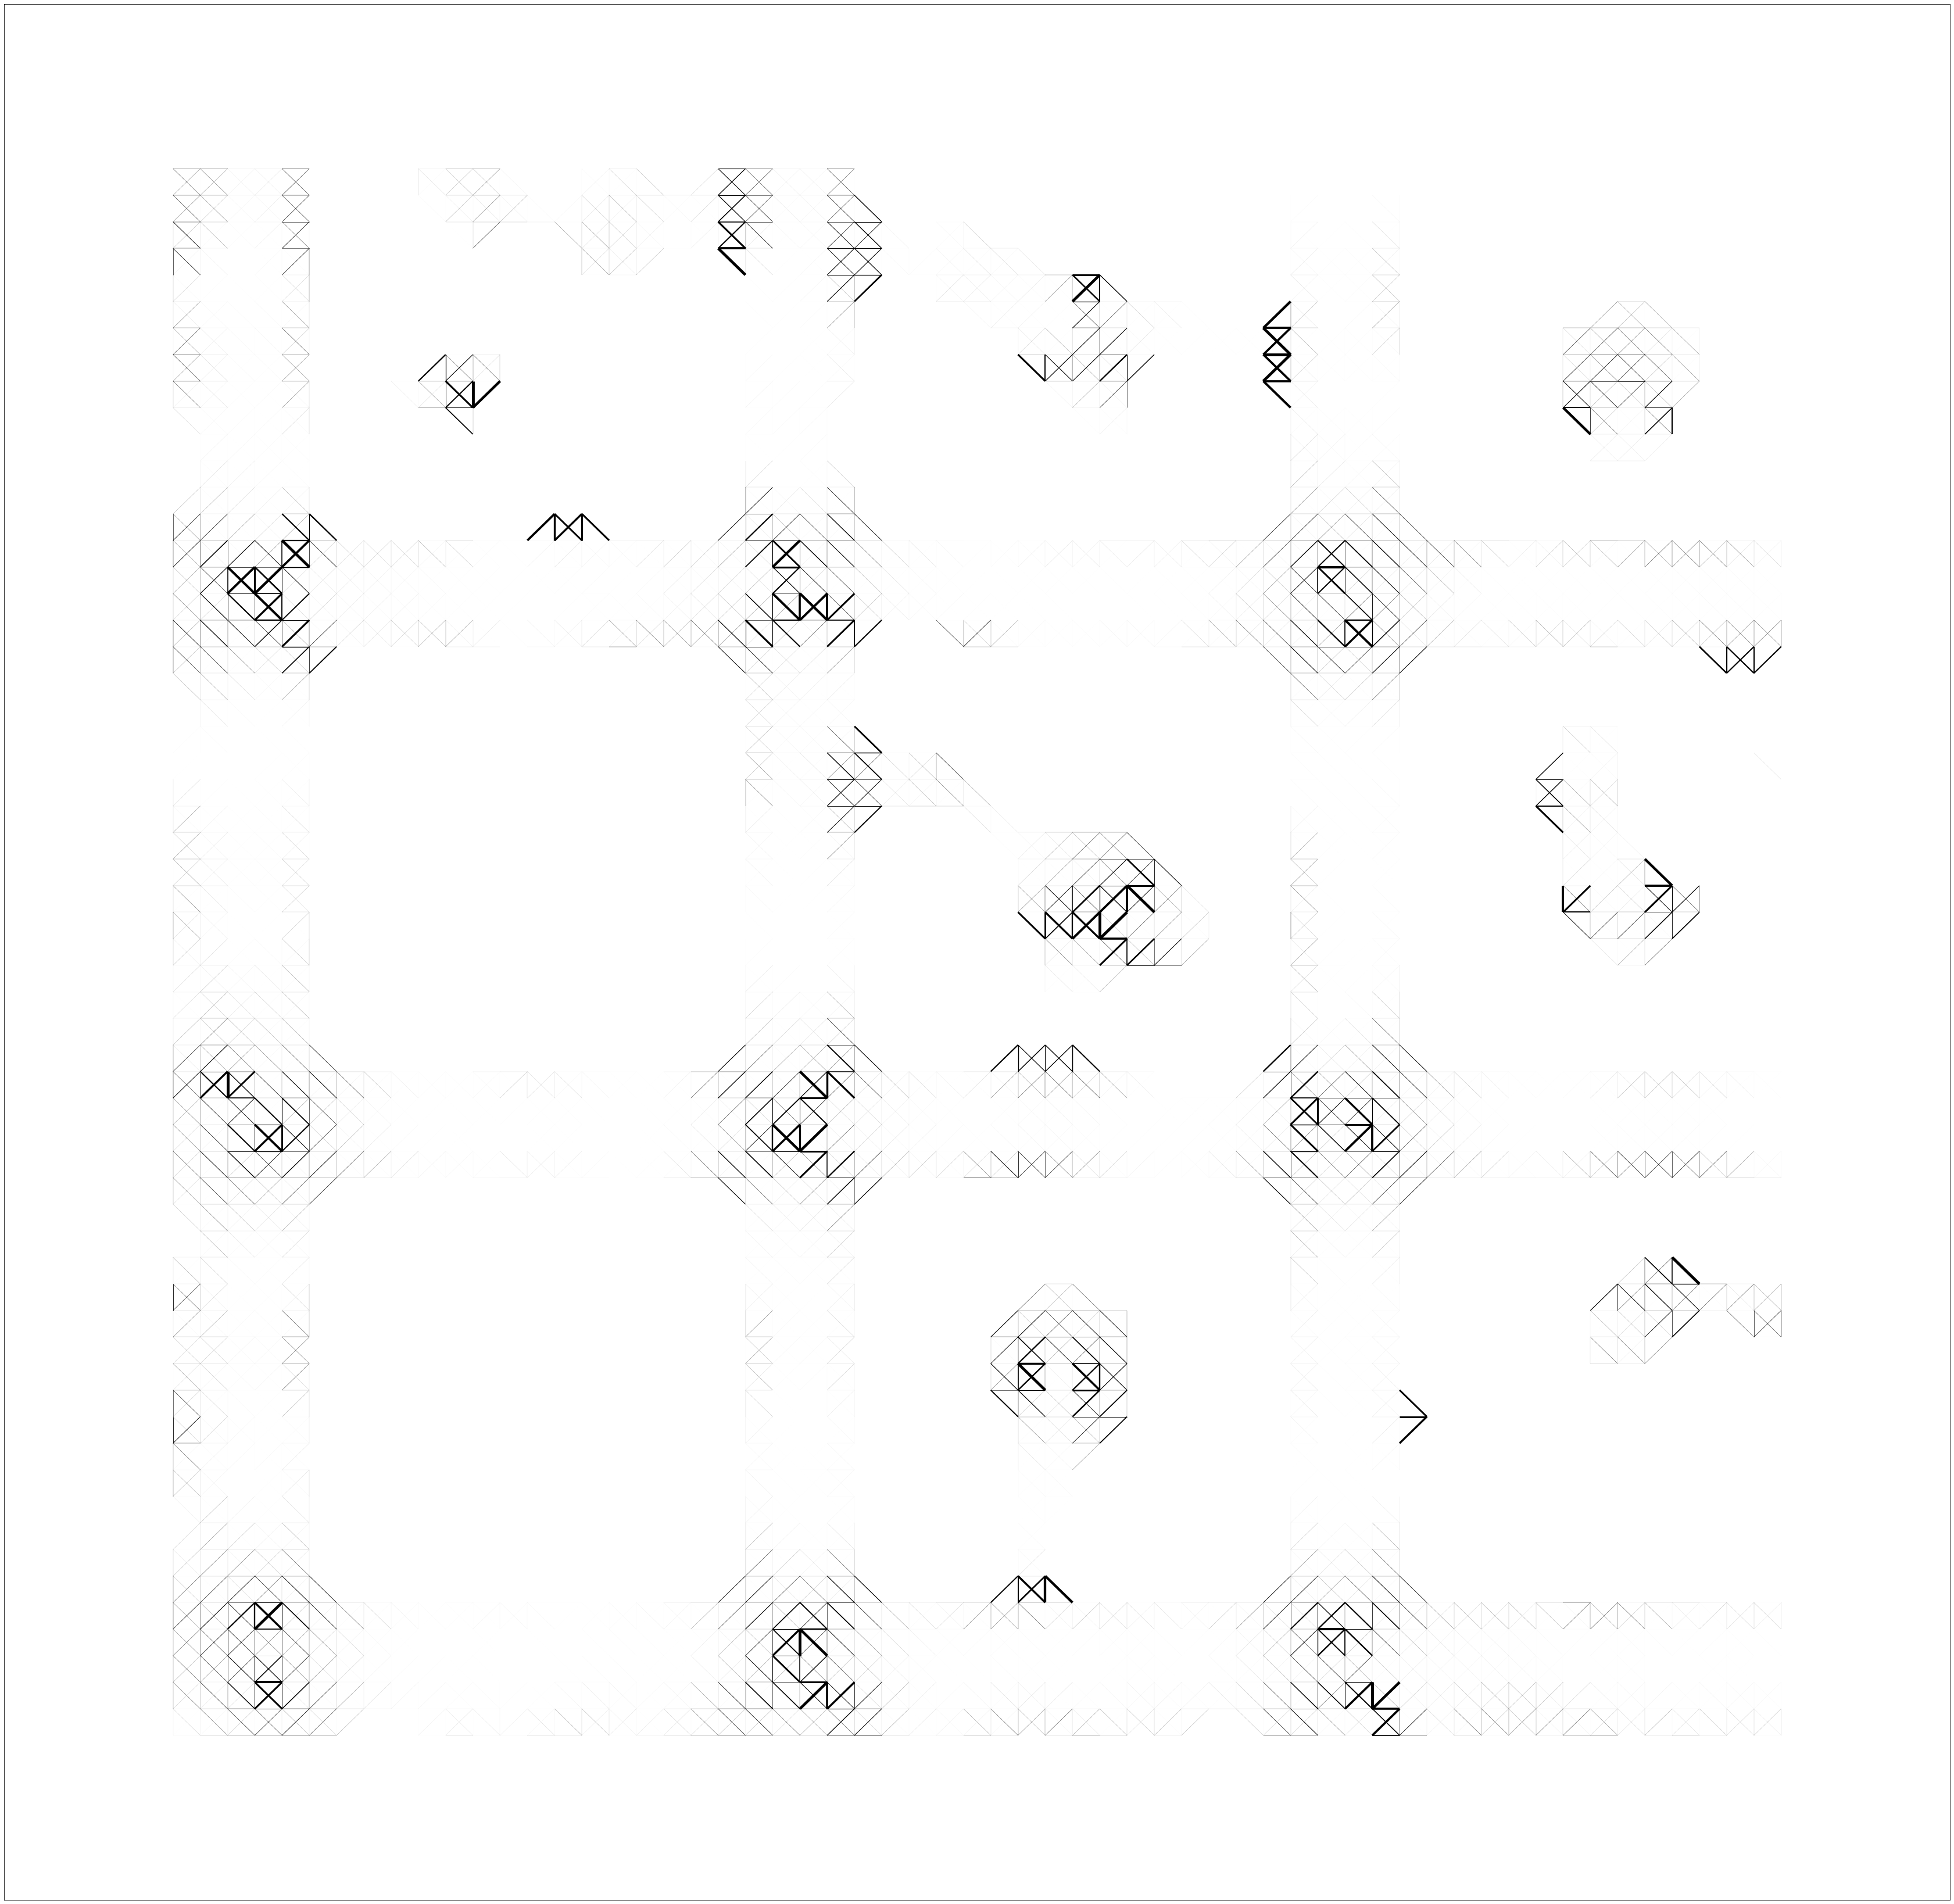

In [105]:
# %matplotlib notebook
plt.figure(figsize=(60, 60))
width = 1 - np.array([edgedata["weight"] for _, _, edgedata in Gn.edges(data=True)])
# width = np.where(width > -0.1, np.zeros(width.shape), width)
nx.draw_networkx_edges(Gn, nodes, width=width*5)
# imshow(clean_img, cmap='gray', origin='lower')

In [100]:
ves = astro.morpho.vesselness(final_image, 2)

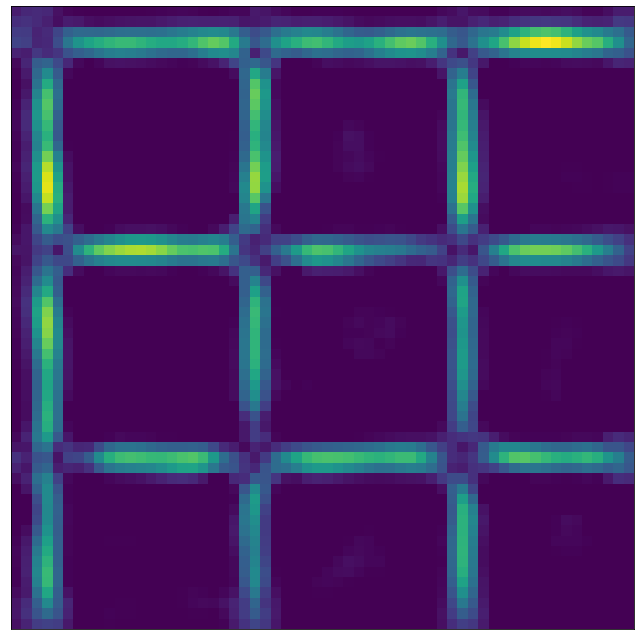

In [101]:
plt.figure(figsize=(11,9))
# imshow(final_image, cmap='gray', origin='lower')

imshow(ves)
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.tight_layout()

In [111]:
blobs = astro.morpho.round_blobs(sato)

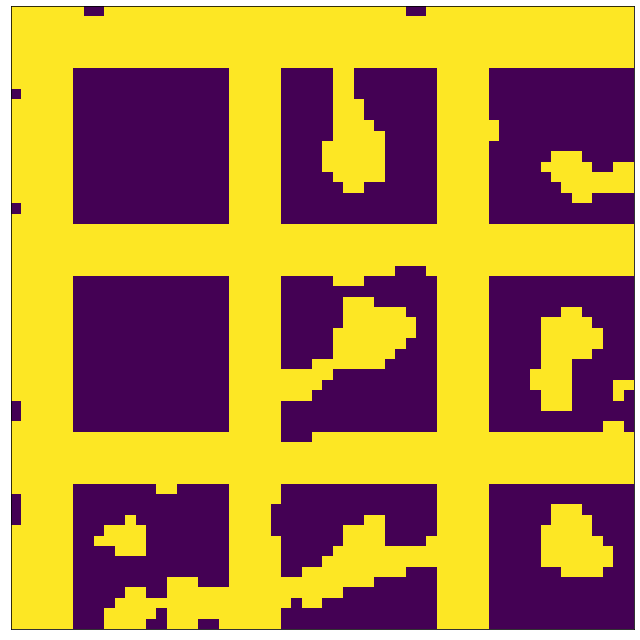

In [112]:
plt.figure(figsize=(11,9))
# imshow(final_image, cmap='gray', origin='lower')

imshow(blobs)
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.tight_layout()

## Gabor filter

## 3Dvectors

In [16]:
import hessian_vectors as hv
import napari

In [25]:
sigma = 0.5

In [26]:
sato, Vf = astro.hessian.sato3d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

In [27]:
sato2 = np.where((sato**0.5) < 0.3, np.zeros(sato.shape), sato)

In [28]:
viewer = napari.view_image(final_image)
hv.plot_from_sato(viewer, sato2, Vf)
napari.run()

In [46]:
from skimage.filters import ridges as skridges
# @jit
def vesselness(img, sigma, cc=2., beta=0.5):
    #H = skf.hessian_matrix(img,sigma)
    #Hl = skf.hessian_matrix_eigvals(H)
    Hl = skridges.compute_hessian_eigenvalues(img, sigma)
    print(Hl.shape)
    sh = img.shape
    v = np.zeros(sh)
    for r in range(sh[0]):
        for c in range(sh[1]):
            for h in range(sh[2]):
                l1,l2 = Hl[0][r,c,h], Hl[1][r,c,h]
    #             print(np.abs(l1))
                if np.linalg.norm(l2) < np.linalg.norm(l1):
                    l1,l2 = l2,l1
                s = np.sqrt(l1**2 + l2**2)

                if l2 >= 0:
                    v[r,c,h] = 0
                else:
                    Rb = l1/l2
                    v[r,c,h] =  (1 - np.exp(-s**2/(2*cc**2)))*np.exp(-(Rb**2)/(2*beta**2))
                    #v[r,c] =  (1 - exp(-(0**2)/(2*c**2)))
                    pass
    return v

In [47]:
ves = vesselness(final_image, 3)
viewer = napari.view_image(ves)

ves = vesselness(final_image, 2)
viewer.add_image(ves)

ves = vesselness(final_image, 1)
viewer.add_image(ves)

ves = vesselness(final_image, 0.5)
viewer.add_image(ves)


(3, 79, 230, 230)


(3, 79, 230, 230)
(3, 79, 230, 230)
(3, 79, 230, 230)


<Image layer 'ves [3]' at 0x7fe4f97609a0>

In [31]:
from skimage.filters import ridges as skridges
skridges.compute_hessian_eigenvalues(final_image, 1)

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

## Скелетонизация

Определение Сомы и её границ

Определение узлов/пересечений 

Определение центральной линии отростков последовательным перемещением по границе сомы и выделением самых ярких участков. Перемещение по вектору и снова поиск.
